# Visualization - Dynamic Agents


### The Boltzmann Wealth Model 

### Import Dependencies
This includes importing of dependencies needed for the tutorial.

In [1]:
# Has multi-dimensional arrays and matrices.
# Has a large collection of mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid

# Check Mesa version for visualization compatibility
if mesa.__version__.startswith(("3.0", "3.1", "3.2")):
    print(
        f"⚠️  Mesa {mesa.__version__} detected. Visualization features require Mesa 3.3+"
    )
    print("To upgrade: pip install --upgrade mesa")

from mesa.visualization import SolaraViz, SpaceRenderer, make_plot_component
from mesa.visualization.components import AgentPortrayalStyle

## Basic Model

The following is the basic model we will be using to build the dashboard. This is the same model seen in tutorials 0-3. 

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, cell):
        """initialize a MoneyAgent instance.

        Args:
            model: A model instance
        """
        super().__init__(model)
        self.cell = cell
        self.wealth = 1

    def move(self):
        """Move the agent to a random neighboring cell."""
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        """Give 1 unit of wealth to a random agent in the same cell."""
        cellmates = [a for a in self.cell.agents if a is not self]

        if cellmates:  # Only give money if there are other agents present
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        """do one step of the agent."""
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n=10, width=10, height=10, rng=None):
        """Initialize a MoneyModel instance.

        Args:
            N: The number of agents.
            width: width of the grid.
            height: Height of the grid.
        """
        super().__init__(rng=rng)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # Create agents
        MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
        self.datacollector.collect(self)

    def step(self):
        """do one step of the model"""
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

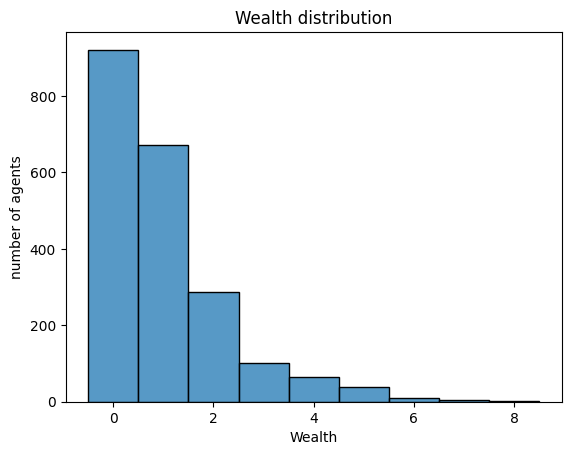

In [3]:
# Lets make sure the model works
model = MoneyModel(100, 10, 10)
model.run_for(20)


data = model.datacollector.get_agent_vars_dataframe()
# Use seaborn
g = sns.histplot(data["Wealth"], discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="number of agents");

### Adding visualization

So far, we've built a model, run it, and analyzed some output afterwards. However, one of the advantages of agent-based models is that we can often watch them run step by step, potentially spotting unexpected patterns, behaviors or bugs, or developing new intuitions, hypotheses, or insights. Other times, watching a model run can explain it to an unfamiliar audience better than static explanations. Like many ABM frameworks, Mesa allows you to create an interactive visualization of the model. In this section we'll walk through creating a visualization using built-in components, and (for advanced users) how to create a new visualization element.

First, a quick explanation of how Mesa's interactive visualization works. The visualization is done in a browser window or Jupyter instance, using the [Solara](https://solara.dev/) framework, a pure Python, React-style web framework. Running `solara run app.py` will launch a web server, which runs the model, and displays model detail at each step via a plotting library. Alternatively, you can execute everything inside a Jupyter instance and display it inline.

## Dynamic Agent Representation

In the first visualization, all we could see is the agents moving around -- but not how much money they had, or anything else of interest. In this tutorial let's change it so that agents are represented by the units of wealth they have. So those who are broke (wealth 0) are drawn in red, smaller. 

Since Mesa is open source, if you have ideas to improve the visualization stack, feel free to [contribute](https://github.com/mesa/mesa/blob/main/CONTRIBUTING.md).

When using the default drawer, an agent's shape can be customized in addition to its size and color.

* For `matplotlib`, allowed shape values can be found [here](https://matplotlib.org/stable/api/markers_api.html).
* For `altair`, supported shapes include: `"circle"`, `"square"`, `"cross"`, `"diamond"`, `"triangle-up"`, `"triangle-down"`, `"triangle-right"`, and `"triangle-left"`.

**Note:**
Always check which backend is being used before assigning shapes. If a shape name doesn't match what's supported by the selected backend, it may cause errors.

In some cases, Mesa implicitly converts common shape names between Altair and Matplotlib (e.g., from Altair to Matplotlib), but this mapping is limited—and there's no support for conversion in the reverse direction (Matplotlib to Altair).


To do this, we go back to our `agent_portrayal` code and add some code to change the portrayal based on the agent properties and launch the server again.

In [4]:
def agent_portrayal(agent):
    portrayal = AgentPortrayalStyle(size=50, color="tab:orange")
    if agent.wealth > 0:
        portrayal.update(("color", "tab:blue"), ("size", 100))
    return portrayal

As like last time we then instantiate the model parameters, some of which are modifiable by user inputs. In this case, the number of agents, N, is specified as a slider of integers.

In [5]:
model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

Then just like last time we instantiate the visualization object which (by default) displays the grid containing the agents, and timeseries of values computed by the model's data collector. In this example, we specify the Gini coefficient.

There are 3 main buttons (we will discuss the play interval, render interval and use threads in lesson 6):
- the step button, which advances the model by 1 step
- the play button, which advances the model indefinitely until it is paused
- the pause button, which pauses the model

To reset the model, the order of operations are important
1. Stop the model
2. Update the parameters (e.g. move the sliders)
3. Press reset 

### Page Tab View

#### **Plot Components**
You can place different components (except the renderer) on separate pages according to your preference. There are no restrictions on page numbering — pages do not need to be sequential or positive. Each page acts as an independent window where components may or may not exist.

The default page is `page=0`. If pages are not sequential (e.g., `page=1` and `page=10`), the system will automatically create the 8 empty pages in between to maintain consistent indexing. To avoid empty pages in your dashboard, use sequential page numbers.

To assign a plot component to a specific page, pass the `page` keyword argument to `make_plot_component`. For example, the following will display the plot component on page 1:

```python
plot_comp = make_plot_component("encoding", page=1)
```

#### **Custom Components**
In tutorial 8, you will learn how to create custom components for the Solara dashboard. If you want a custom component to appear on a specific page, you must pass it as a tuple containing the component and the page number.

```python
@solara.component
def CustomComponent():
    ...

page = SolaraViz(
    model,
    renderer,
    components=[(CustomComponent, 1)]  # Custom component will appear on page 1
)
```

> ⚠️ **Warning**
> Running the model can be performance-intensive. It is strongly recommended to pause the model in the dashboard before switching pages.

In [6]:
# Create initial model instance
money_model = MoneyModel(n=50, width=10, height=10)
renderer = (
    SpaceRenderer(model=money_model, backend="matplotlib")
    .setup_agents(agent_portrayal)
    .render()
)

GiniPlot = make_plot_component("Gini")

page = SolaraViz(
    money_model,
    renderer,
    components=[GiniPlot],
    model_params=model_params,
    name="Boltzmann Wealth Model",
)
# This is required to render the visualization in the Jupyter notebook
page

Cannot show ipywidgets in text

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.” arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.